# MAFAULDA. Machinery Fault Database

Dataset source: http://www02.smt.ufrj.br/~offshore/mfs/page_01.html

In [1]:
import os
from glob import glob
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.datasets import load_from_arff_to_dataframe
from sktime.classification.interval_based import (
    CanonicalIntervalForest,
    DrCIF,
    RandomIntervalSpectralEnsemble,
    SupervisedTimeSeriesForest,
    TimeSeriesForestClassifier,
)
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_3d_numpy_to_multi_index,
    from_multi_index_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_3d_numpy
)
from sktime.classification.kernel_based import Arsenal
from sktime.datasets import load_from_tsfile
from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mcfly.modelgen import generate_models
from mcfly.find_architecture import train_models_on_samples
import matplotlib.pyplot as plt
from collections import Counter
from timeit import default_timer as timer
from datetime import timedelta
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

SEED=42

%matplotlib inline

In [ ]:
%%time 

# data_path = "/mnt/f/Downloads/MAFAULDA/"
data_path = "C:/Users/NABS/Downloads/mafaulda-full"
data_paths = {
    "normal": os.path.join(data_path,"normal"),
    "overhang-cage-fault-20g": os.path.join(data_path, "overhang/cage_fault/20g"),
    # "imbalance-20g": data_path + "imbalance/20g/"
}
TIME_SERIES_LENGTH = 5000
df = pd.DataFrame()
labels = []

for k, val in data_paths.items():
    label = k
    print("label:", label)
    
    for file_name in listdir(val):
        print("file_name", file_name)
        df_tmp = pd.read_csv(os.path.join(val, file_name), header=None)[0:TIME_SERIES_LENGTH]
        df_tmp = df_tmp.astype("float32")
        
        instance_id = file_name.split(".csv")[0] + "_" + label
        df_tmp["instances"] = instance_id
        df_tmp["timepoints"] = list(range(len(df_tmp)))
        # df_tmp["label"] = label
        labels.append(label)

        # print("file_id:", instance_id, "df_tmp length:", len(df_tmp))
        df = pd.concat([df, df_tmp])
    del df_tmp

print("Finished")

In [3]:
df.columns = ['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 'instances', 'timepoints']
df = df[['instances', 'timepoints', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7']]
df = df.set_index(['instances', 'timepoints'])
df.head()

s0        s1        s2        s3       s4  \
instances     timepoints                                                  
12.288_normal 0           4.5595  0.175200  0.287210 -0.017751 -0.41565   
              1           4.6038 -0.051295 -0.194050 -0.060071 -0.41809   
              2           4.5703 -0.969080  0.038033 -0.028329 -0.43081   
              3           4.5870  0.891270  0.072973  0.007453 -0.40017   
              4           4.5887 -1.716000 -0.329290 -0.033063 -0.50281   

                                s5       s6        s7  
instances     timepoints                               
12.288_normal 0           0.032459 -0.11218 -0.128140  
              1           0.036547 -0.11043  0.118310  
              2           0.041924 -0.14331 -0.071527  
              3           0.041090 -0.11984  0.043445  
              4           0.040474 -0.25270  0.023901

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 490000 entries, ('12.288_normal', 0) to ('61.2352_overhang-cage-fault-20g', 4999)
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   s0      490000 non-null  float32
 1   s1      490000 non-null  float32
 2   s2      490000 non-null  float32
 3   s3      490000 non-null  float32
 4   s4      490000 non-null  float32
 5   s5      490000 non-null  float32
 6   s6      490000 non-null  float32
 7   s7      490000 non-null  float32
dtypes: float32(8)
memory usage: 16.5+ MB


In [5]:
%%time

df_nested = from_multi_index_to_nested(multi_ind_dataframe=df, instance_index='instances')
df_nested.head()

CPU times: total: 797 ms
Wall time: 791 ms


,s0,s1,s2,s3,s4,s5,s6,s7
instances,,,,,,,,
12.288_normal,0 4.55950 1 4.60380 2 4.5703...,0 0.175200 1 -0.051295 2 -0.96...,0 0.287210 1 -0.194050 2 0.03...,0 -0.017751 1 -0.060071 2 -0.02...,0 -0.41565 1 -0.41809 2 -0.4308...,0 0.032459 1 0.036547 2 0.04...,0 -0.112180 1 -0.110430 2 -0.14...,0 -0.128140 1 0.118310 2 -0.07...
13.1072_normal,0 -0.52828 1 -0.52552 2 -0.5220...,0 -1.68410 1 1.47330 2 -1.8994...,0 -0.029689 1 0.148640 2 -0.34...,0 -0.001552 1 0.037974 2 -0.01...,0 1.0739 1 1.1268 2 1.0357 3...,0 -0.017822 1 -0.024118 2 -0.02...,0 0.17262 1 0.21368 2 0.1238...,0 -0.039353 1 -0.003820 2 0.05...
14.336_normal,0 4.47690 1 4.46430 2 4.4941...,0 -1.70450 1 1.72010 2 -1.6053...,0 -0.076488 1 0.273950 2 -0.25...,0 -0.051497 1 0.021210 2 -0.07...,0 -0.567210 1 -0.452910 2 -0.57...,0 0.041456 1 0.039043 2 0.03...,0 -0.031897 1 0.069768 2 -0.04...,0 0.040889 1 -0.033122 2 0.19...
15.1552_normal,0 4.55540 1 4.53610 2 4.5689...,0 -2.18540 1 1.43250 2 -2.0092...,0 -0.231230 1 0.297630 2 -0.45...,0 -0.088589 1 -0.009870 2 -0.08...,0 1.31250 1 1.36200 2 1.2812...,0 0.004337 1 0.002316 2 0.00...,0 0.30016 1 0.37897 2 0.3388...,0 0.035949 1 -0.049696 2 0.15...
16.1792_normal,0 4.49670 1 4.62210 2 4.5235...,0 0.972110 1 1.062900 2 0.49...,0 0.352170 1 0.117360 2 0.26...,0 0.071360 1 0.066884 2 0.08...,0 -0.32078 1 -0.31932 2 -0.3239...,0 0.004632 1 0.008688 2 0.00...,0 -0.12409 1 -0.16927 2 -0.2045...,0 -0.082553 1 -0.038890 2 -0.09...


In [6]:
df_nested.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 12.288_normal to 61.2352_overhang-cage-fault-20g
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s0      98 non-null     object
 1   s1      98 non-null     object
 2   s2      98 non-null     object
 3   s3      98 non-null     object
 4   s4      98 non-null     object
 5   s5      98 non-null     object
 6   s6      98 non-null     object
 7   s7      98 non-null     object
dtypes: object(8)
memory usage: 6.9+ KB


In [7]:
df_nested.shape + df_nested.iloc[0,0].shape

(98, 8, 5000)

In [8]:
del df

In [9]:
def transform_data(transformer, x_train, x_test):
    print("Starting data transformation ...")
    
    start = timer()
    transformer.fit(x_train)
    print(f"Elapsed time for {type(transformer).__name__} fitting:", 
          (timedelta(seconds=timer()-start)).seconds, 
          "seconds")
    
    start = timer()
    x_train_transform = transformer.transform(x_train)
    print("Elapsed time for the transformation of X_train:", (timedelta(seconds=timer()-start)).seconds, "seconds")
    
    start = timer()
    x_test_transform = transformer.transform(x_test)
    print("Elapsed time for the transformation of X_test:", (timedelta(seconds=timer()-start)).seconds, "seconds \n")
    
    return x_train_transform, x_test_transform


def get_model_name(model):
    return type(model).__name__


def train_model(model, X_train, y_train):
    model_name = get_model_name(model)
    
    print(f"Starting {model_name} model training ...")
    start = timer()
    model = model.fit(X_train, y_train)
    print(f"Elapsed time for the {model_name} model training:", 
          (timedelta(seconds=timer()-start)).seconds, 
          "seconds \n")
    return model

def evaluate_model(model, x_test, y_test):
    model_name = get_model_name(model)
    print(f"Starting {model_name} model evaluation ...")

    start = timer()
    y_pred = model.predict(x_test)
    print(f"Elapsed time for the {model_name} model prediction:", 
      (timedelta(seconds=timer()-start)).seconds, 
      "seconds \n")
    
    print(f"Classification Report for the {model_name} model \n")
    print(classification_report(y_test, y_pred, digits=4))
    
    print("")
    # print("F1 binary:\t", f1_score(y_test, y_pred))
    print("F1 micro:\t", round(f1_score(y_test, y_pred, average="micro"), 4))
    print("F1 macro:\t", round(f1_score(y_test, y_pred, average="macro"), 4))
    print("F1 weighted:\t", round(f1_score(y_test, y_pred, average="weighted"), 4))
    print("")

In [10]:
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(df_nested, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=labels, 
                                                    shuffle=True)

print("Data shape: (examples, channels, series_length)\n")
print("X_train shape:\t", X_train.shape + X_train.iloc[0,0].shape)
print("y_train shape:\t", y_train.shape)

print("X_test shape:\t", X_test.shape + X_test.iloc[0,0].shape)
print("y_test shape:\t", y_test.shape)

Data shape: (examples, channels, series_length)

X_train shape:	 (78, 8, 5000)
y_train shape:	 (78,)
X_test shape:	 (20, 8, 5000)
y_test shape:	 (20,)


## Data transformation using MiniROCKET

In [11]:
%%time 

mini_rocket = MiniRocketMultivariate(n_jobs=6, random_state=SEED)

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
%%time

mini_rocket = mini_rocket.fit(X_train)

CPU times: total: 27.7 s
Wall time: 27.9 s


In [13]:
%%time

X_train_transform = mini_rocket.transform(X_train)

CPU times: total: 1min 3s
Wall time: 56 s


In [14]:
%%time

X_test_transform = mini_rocket.transform(X_test)

CPU times: total: 17 s
Wall time: 14.4 s


## MiniROCKET features + RidgeClassifierCV

In [15]:
%%time 

model = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
model = train_model(model, X_train_transform, y_train)
evaluate_model(model, X_test_transform, y_test)

Starting RidgeClassifierCV model training ...
Elapsed time for the RidgeClassifierCV model training: 0 seconds 

Starting RidgeClassifierCV model evaluation ...
Elapsed time for the RidgeClassifierCV model prediction: 0 seconds 

Classification Report for the RidgeClassifierCV model 

                         precision    recall  f1-score   support

                 normal     1.0000    1.0000    1.0000        10
overhang-cage-fault-20g     1.0000    1.0000    1.0000        10

               accuracy                         1.0000        20
              macro avg     1.0000    1.0000    1.0000        20
           weighted avg     1.0000    1.0000    1.0000        20


F1 micro:	 1.0
F1 macro:	 1.0
F1 weighted:	 1.0

CPU times: total: 141 ms
Wall time: 122 ms


## Raw data + Mcfly AutoML

### Data preparation for deep learning models

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_train,
                                                  shuffle=True)

print("Data shape: (examples, channels, series_length)\n")
print("X_train shape:\t", X_train.shape + X_train.iloc[0,0].shape)
print("y_train shape:\t", y_train.shape)

print("X_val shape:\t", X_val.shape + X_val.iloc[0,0].shape)
print("y_val shape:\t", y_val.shape)

Data shape: (examples, channels, series_length)

X_train shape:	 (62, 8, 5000)
y_train shape:	 (62,)
X_val shape:	 (16, 8, 5000)
y_val shape:	 (16,)


In [17]:
oh_encoder = OneHotEncoder()
oh_encoder = oh_encoder.fit(y_train.reshape(-1, 1))

oh_encoder.categories_

[array(['normal', 'overhang-cage-fault-20g'], dtype='<U23')]

In [18]:
y_train_binary = oh_encoder.transform(y_train.reshape(-1, 1)).toarray()
y_val_binary = oh_encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_binary = oh_encoder.transform(y_test.reshape(-1, 1)).toarray()

In [19]:
X_train_np = np.swapaxes(from_nested_to_3d_numpy(X_train), 1, 2)
X_val_np = np.swapaxes(from_nested_to_3d_numpy(X_val), 1, 2)
X_test_np = np.swapaxes(from_nested_to_3d_numpy(X_test), 1, 2)

In [20]:
print('X_train_np.shape:', X_train_np.shape)
print('y_train_binary.shape:', y_train_binary.shape)
print('X_val_np.shape:', X_val_np.shape)
print('y_val_binary.shape:', y_val_binary.shape)
print('X_test_np.shape:', X_test_np.shape)
print('y_test_binary.shape:', y_test_binary.shape)

X_train_np.shape: (62, 5000, 8)
y_train_binary.shape: (62, 2)
X_val_np.shape: (16, 5000, 8)
y_val_binary.shape: (16, 2)
X_test_np.shape: (20, 5000, 8)
y_test_binary.shape: (20, 2)


In [21]:
%%time

num_classes = y_train_binary.shape[1]
metric = 'binary_accuracy'
models = generate_models(X_train_np.shape,
                         number_of_classes=num_classes,
                         number_of_models = 10,
                         model_types=['ResNet', 'InceptionTime'],
                         metrics=[metric])

CPU times: total: 3.75 s
Wall time: 3.94 s


In [22]:
# Define directory where the results, e.g. json file, will be stored
directory_to_extract_to = '../'
resultpath = os.path.join(directory_to_extract_to, 'models')
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [ ]:
%%time

outputfile = os.path.join(resultpath, 'modelcomparison-mcfly-mafaulda.json')
histories, val_accuracies, val_losses =\
    train_models_on_samples(X_train_np,
                            y_train_binary,
                            X_val_np,
                            y_val_binary,
                            models,
                            batch_size=5,
                            nr_epochs=20,
                            # subset_size=1000,
                            verbose=True,
                            outputfile=outputfile,
                            metric=metric)

print('Details of the training process were stored in ', outputfile)

In [24]:
# metric = 'accuracy'
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_{}'.format(metric): [history.history[metric][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_{}'.format(metric): [history.history['val_{}'.format(metric)][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons.to_csv(os.path.join(resultpath, 'modelcomparisons.csv'))

modelcomparisons

,model,train_binary_accuracy,train_loss,val_binary_accuracy,val_loss
0,"{'learning_rate': 0.002481868406666024, 'regul...",1.000000,0.002369,0.9375,0.103386
1,"{'learning_rate': 0.0020733359290859917, 'regu...",0.983871,0.116505,0.8750,1.105585
2,"{'learning_rate': 0.0012641972520448417, 'regu...",0.967742,0.099978,0.5625,31.412218
3,"{'learning_rate': 0.062298458109085804, 'regul...",0.951613,0.101985,0.5000,60.795021
4,"{'learning_rate': 0.001952196671677146, 'regul...",0.983871,0.058612,0.7500,0.385597
5,"{'learning_rate': 0.010253295496107573, 'regul...",0.919355,0.270251,0.9375,0.065304
6,"{'learning_rate': 0.001400221150606459, 'regul...",0.887097,0.376523,0.7500,9.517092
7,"{'learning_rate': 0.00010725006100452288, 'reg...",1.000000,0.028000,0.9375,0.112293
8,"{'learning_rate': 0.0016082190081896767, 'regu...",0.967742,0.150520,1.0000,0.110044
9,"{'learning_rate': 0.0032481413299388015, 'regu...",0.935484,0.136014,0.6250,46.903671


In [25]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print("best_model_index:", best_model_index)
print(best_model_types)
print(best_params)

Model type and parameters of the best model:
best_model_index: 0
InceptionTime
{'learning_rate': 0.002481868406666024, 'regularization_rate': 0.00040507278590498885, 'network_depth': 6, 'filters_number': 53, 'max_kernel_size': 63}


In [ ]:
#We make a copy of the model, to start training from fresh
nr_epochs = 50
datasize = X_train_np.shape[0] # Change in `X_train.shape[0]` if training complete data set

history = best_model.fit(
    X_train_np[:datasize,:,:],
    y_train_binary[:datasize,:],
    epochs=nr_epochs,
    validation_data=(X_val_np, y_val_binary)
)

In [26]:
## Test on Testset
score_test = best_model.evaluate(X_test_np, y_test_binary, verbose=True)
print('Score of best model')
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

1/1 [==============================] - 2s 2s/step - loss: 0.0333 - binary_accuracy: 1.0000
Score of best model
Test loss: 0.03331084921956062
Test accuracy: 1.0


## Data transformation duration estimation

In [20]:
ts_length = [1000, 5000, 10000, 130000]
transformation_duration = [13, 99, 170, 2100]

pd.DataFrame({"time series length": ts_length, "transformation duration (in sec)": transformation_duration})

,time series length,transformation duration (in sec)
0,1000,13
1,5000,99
2,10000,170
3,130000,2100


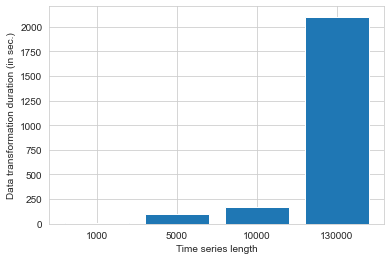

In [30]:
plt.bar([str(x) for x in ts_length], transformation_duration)
plt.xlabel("Time series length")
plt.ylabel("Data transformation duration (in sec.)")
plt.show()

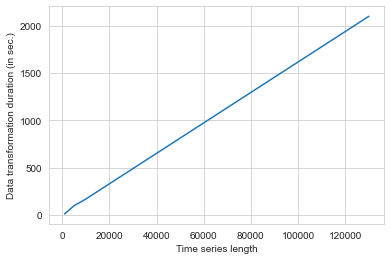

In [37]:
# fig1 = plt.figure(figsize=(15, 8))
plt.plot(ts_length, transformation_duration)
plt.xlabel("Time series length")
plt.ylabel("Data transformation duration (in sec.)")
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(ts_length.reshape(-1, 1), transformation_duration)

print("Score:", reg.score(ts_length.reshape(-1, 1), transformation_duration))

print("Coefficients:", reg.coef_)

print("Intercept:", reg.intercept_)

print("Prediction:", reg.predict(np.array([[30000]])))

Score: 0.9999224208005628
Coefficients: [0.01609515]
Intercept: 8.026929982046681
Prediction: [490.88150808]


Linear regression: `Y = 0.0161 * X + 8.03`

In [39]:
num_new_instances = ((100 - 30 + 1) * 105)
duration_sec = num_new_instances * 490

print(f"Transformation of all {num_new_instances} sliding windows using the MiniRocket will take approximately:")

print("\u2022", duration_sec, "seconds or")
print("\u2022", round(duration_sec/60), "minutes or")
print("\u2022", round(duration_sec/3600), "hours")

Transformation of all 7455 sliding windows using the MiniRocket will take approximately:
• 3652950 seconds or
• 60882 minutes or
• 1015 hours


Transformation of all `7455` sliding windows of size `30 seconds` using the MiniRocket will take approximately `1015` hours.